In [1]:
pip install matplotlib pillow

Note: you may need to restart the kernel to use updated packages.


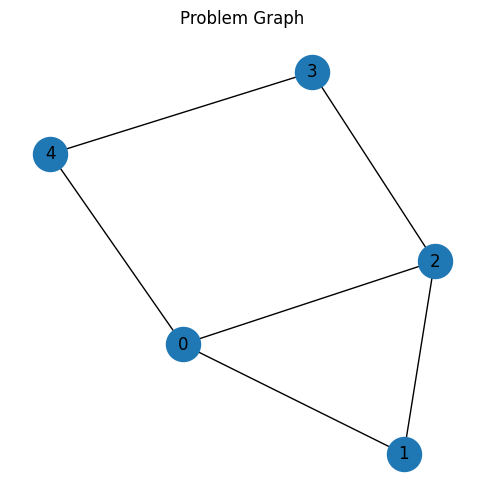

Cost Hamiltonian: SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'],
              coeffs=[2.+0.j, 2.+0.j, 3.+0.j, 2.+0.j, 4.+0.j, 2.+0.j])

Original QAOA Circuit:


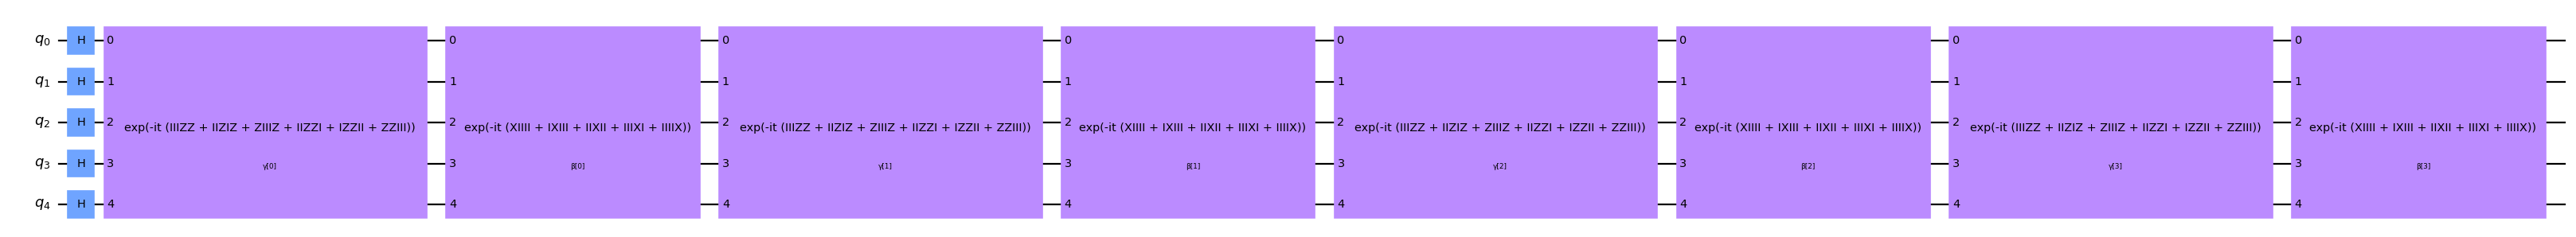


Transpiled QAOA Circuit:


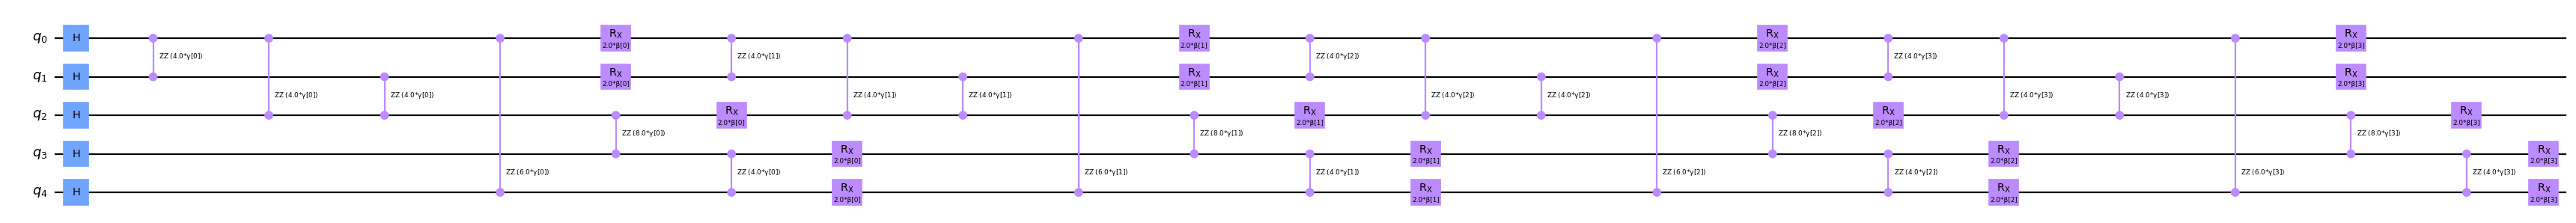

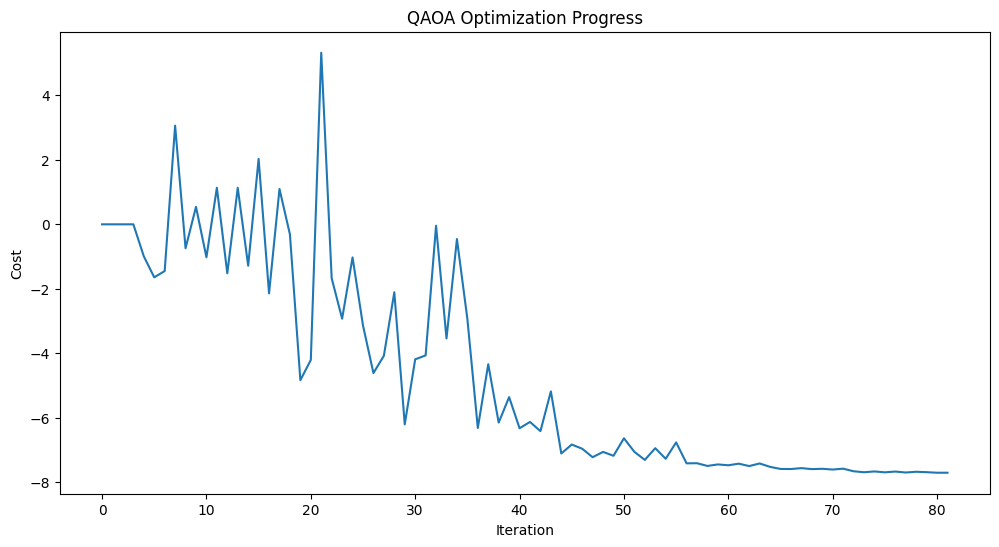


Measurement results: {'01001': 2252, '10001': 263, '10110': 2273, '10010': 76, '11010': 446, '10111': 145, '00100': 21, '01010': 495, '01110': 288, '00101': 429, '01011': 914, '10101': 507, '10100': 946, '00001': 64, '11001': 135, '01100': 47, '01000': 134, '01101': 56, '00010': 77, '11110': 60, '11101': 77, '11100': 7, '11000': 24, '00110': 144, '10011': 48, '11011': 26, '00011': 13, '00111': 24, '01111': 3, '10000': 3, '00000': 2, '11111': 1}

Most likely bitstring: [0, 1, 1, 0, 1]


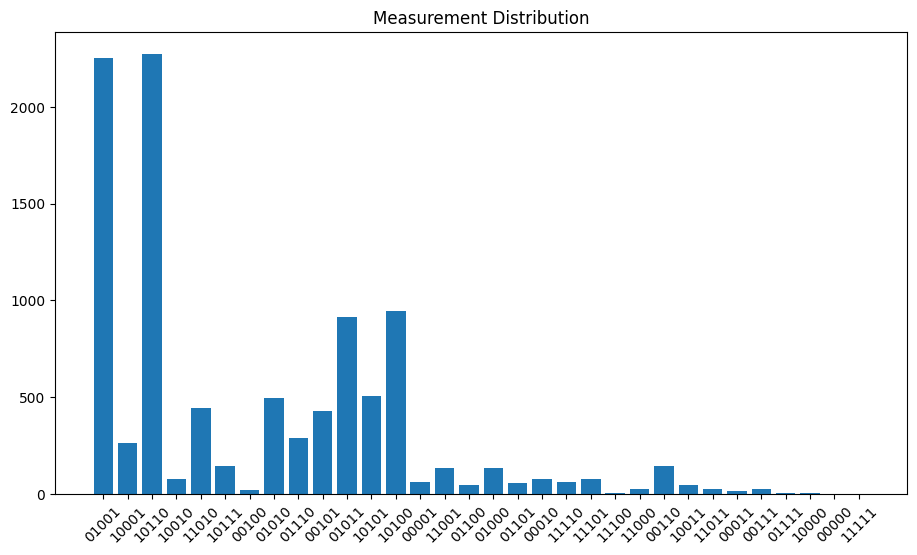


Cut value: 13.0


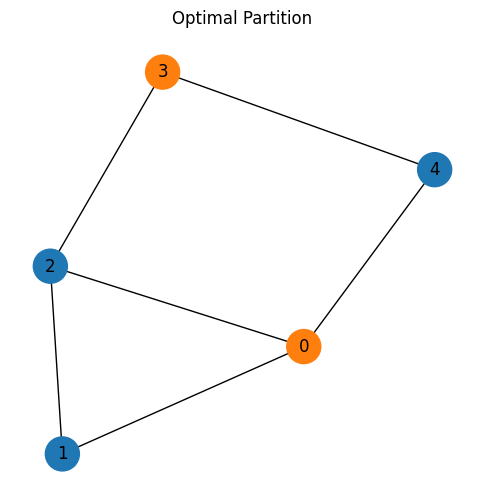

In [2]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.primitives import StatevectorEstimator, StatevectorSampler
from scipy.optimize import minimize
from typing import Sequence
import matplotlib.pyplot as plt

# Configure matplotlib for Jupyter
%matplotlib inline

# Graph setup
n = 5
graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
edge_list = [(0, 1, 2.0), (0, 2, 2.0), (0, 4, 3.0),
            (1, 2, 2.0), (2, 3, 4.0), (3, 4, 2.0)]
graph.add_edges_from(edge_list)

# Draw problem graph
fig, ax = plt.subplots(figsize=(6, 6))
draw_graph(graph, ax=ax, node_size=600, with_labels=True)
plt.title("Problem Graph")
plt.show()

# Hamiltonian construction
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    pauli_list = []
    for edge in graph.edge_list():
        paulis = ["I"] * graph.num_nodes()
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"
        weight = graph.get_edge_data(edge[0], edge[1])
        pauli_list.append(("".join(paulis)[::-1], weight))
    return pauli_list

max_cut_paulis = build_max_cut_paulis(graph)
cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)
print("Cost Hamiltonian:", cost_hamiltonian)

# Create and draw original circuit
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=4)
print("\nOriginal QAOA Circuit:")
display(circuit.decompose().draw("mpl", fold=100, style="clifford", scale=0.8))
plt.close()  # Clean up any extra figures

# Transpile and draw optimized circuit
simulator = AerSimulator()
transpiled_circuit = transpile(circuit, simulator)
print("\nTranspiled QAOA Circuit:")
display(transpiled_circuit.draw("mpl", fold=100, style="clifford", idle_wires=False, scale=0.8))
plt.close()  # Clean up any extra figures

# Optimization setup
initial_params = [np.pi/4] * 8
objective_func_vals = []

def cost_func_estimator(params, ansatz, hamiltonian):
    estimator = StatevectorEstimator()
    bound_ansatz = ansatz.assign_parameters(params)
    job = estimator.run([(bound_ansatz, hamiltonian)])
    return job.result()[0].data.evs

result = minimize(
    cost_func_estimator,
    initial_params,
    args=(transpiled_circuit, cost_hamiltonian),
    method="COBYLA",
    tol=1e-2,
    callback=lambda x: objective_func_vals.append(cost_func_estimator(x, transpiled_circuit, cost_hamiltonian))
)

# Plot optimization progress
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("QAOA Optimization Progress")
plt.show()

# Final measurements
final_circuit = transpiled_circuit.assign_parameters(result.x)
final_circuit.measure_all()

sampler = StatevectorSampler()
counts = sampler.run([final_circuit], shots=10000).result()[0].data.meas.get_counts()

print("\nMeasurement results:", counts)
most_likely_bitstring = max(counts, key=counts.get)[::-1]
print("\nMost likely bitstring:", [int(c) for c in most_likely_bitstring])

# Plot distribution
plt.figure(figsize=(11, 6))
plt.bar(counts.keys(), counts.values())
plt.xticks(rotation=45)
plt.title("Measurement Distribution")
plt.show()

# Cut evaluation
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    return sum(graph.get_edge_data(u, v) * (x[u] != x[v]) for u, v in graph.edge_list())

cut_value = evaluate_sample([int(c) for c in most_likely_bitstring], graph)
print(f"\nCut value: {cut_value}")

# Final visualization
fig, ax = plt.subplots(figsize=(6, 6))
colors = ["#1f77b4" if int(c) else "#ff7f0e" for c in most_likely_bitstring]
draw_graph(graph, ax=ax, node_color=colors, node_size=600, with_labels=True)
plt.title("Optimal Partition")
plt.show()

Generated graph with 20 nodes and 100 edges
Cost Hamiltonian: SparsePauliOp(['IIIIIIIIIIZIIIIZIIII', 'IIIIIIZIIIIIIIIIZIII', 'IIIIIIIIIZIIIIZIIIII', 'IIIIIIIIIIZZIIIIIIII', 'IIZIIIIIIIZIIIIIIIII', 'IIIIIZIIZIIIIIIIIIII', 'IIIIZIIIIIIIIIIIIIZI', 'IIIIIIIIZIIIIZIIIIII', 'IIIIIIIIIZIIZIIIIIII', 'ZZIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIIIIZIIIIIII', 'IIIIIIIIIIIIIZIIZIII', 'IIIIZIIIIIIIIIIIZIII', 'IIIIIIIZIIIIIIZIIIII', 'IIIIIIIIZIIZIIIIIIII', 'IIIIIIIIIZZIIIIIIIII', 'IIIIIIIIIIIIZIIIIIIZ', 'ZIIIIIIIIIZIIIIIIIII', 'IIIIIIIIIIIZIIIIIIZI', 'IIIZZIIIIIIIIIIIIIII', 'IIIIIIIZIIIIZIIIIIII', 'IIZIIZIIIIIIIIIIIIII', 'IIIIIIIZIIZIIIIIIIII', 'IIIIIIIIIIZIIIIIIIIZ', 'IZIIZIIIIIIIIIIIIIII', 'IIZZIIIIIIIIIIIIIIII', 'IIIIIZIIIIIIZIIIIIII', 'IIIIIIZZIIIIIIIIIIII', 'IIIIIIIIIIIIZIZIIIII', 'ZIIIIZIIIIIIIIIIIIII', 'IIIZIIIIIIIIIIZIIIII', 'IZIIIIIIIIIIIIIZIIII', 'IIIIIIIIIIIIIIIIZIZI', 'IIIIZIIIIZIIIIIIIIII', 'IIIIIZZIIIIIIIIIIIII', 'IIIIIIIZIIIIIIIIIIZI', 'ZIIZIIIIIIIIIIIIIIII', 'IIIZIIIIIIIIZIIIIIII', 'IIIIZIIZII


Transpiled QAOA Circuit:


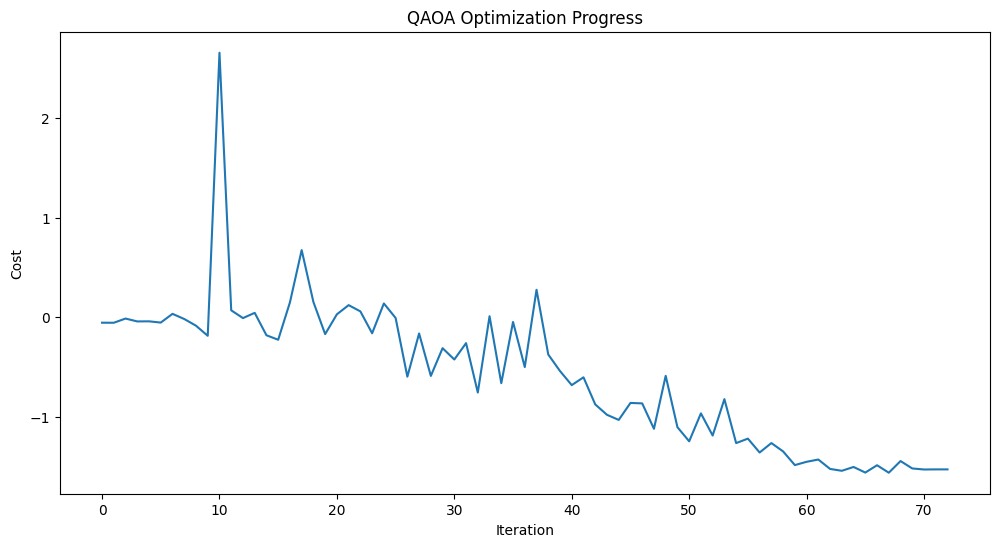


Measurement results: {'01001101011110100001': 1, '11100011110100001001': 1, '10110010100011110110': 1, '01100011001001110010': 1, '01111110001111010111': 1, '10110101010000110011': 1, '00010001101100110110': 1, '11011100101010000010': 1, '00101101011110010110': 1, '11111011000000110100': 1, '00100001100000000010': 1, '11111010010000010000': 1, '00010111110110011100': 1, '01010101110000011001': 1, '00111110001111001110': 1, '11101101010101000011': 1, '00011000010111011000': 1, '00101101100001100010': 1, '01010100100010100110': 1, '10110101001110111011': 1, '01001001111010011010': 1, '11110110101110111110': 1, '11000101111111101101': 1, '10101001001000111000': 1, '10100010001101000111': 1, '01100001101111110110': 1, '00110010001010001100': 1, '11101000110110011001': 1, '11111100110110101110': 1, '10110000100010001010': 1, '01001000011001101111': 1, '01110111100000000110': 1, '11110000011101000110': 1, '10000000110111101010': 1, '11111110010100011000': 1, '10000111101110100010': 1, '0000

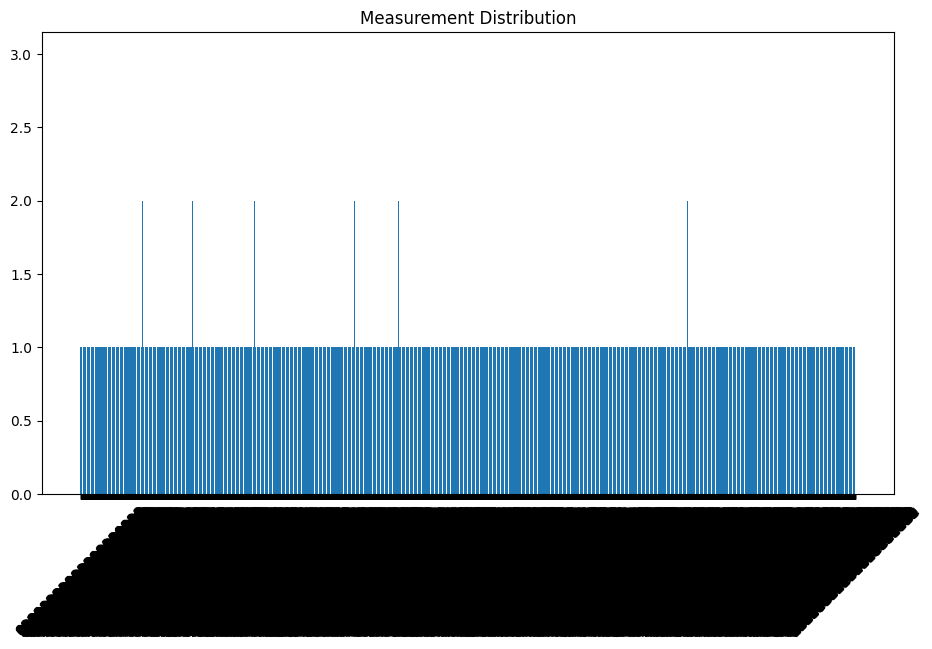


Cut value: 136.3


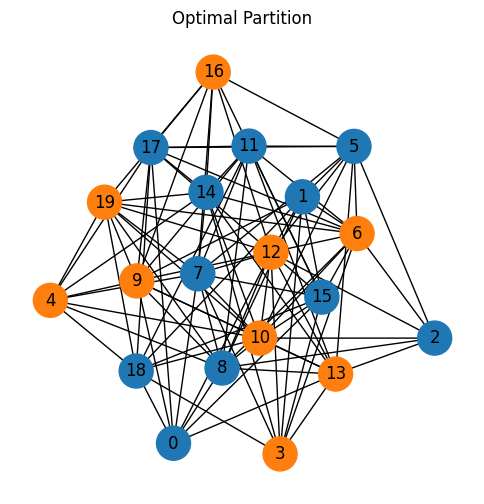

In [3]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.primitives import StatevectorEstimator, StatevectorSampler
from scipy.optimize import minimize
from typing import Sequence
import matplotlib.pyplot as plt
import rustworkx as rx
import numpy as np

# Create empty graph
graph = rx.PyGraph()
n = 20  # Nodes
m = 100  # Edges

# Add nodes
graph.add_nodes_from(range(n))

# Create random edges without duplicates
np.random.seed(42)
edge_set = set()
while len(edge_set) < m:
    u, v = np.random.choice(n, 2, replace=False)
    if u > v:  # Ensure undirected edge uniqueness
        u, v = v, u
    if (u, v) not in edge_set:
        edge_set.add((u, v))

# Add edges with random weights
weights = np.round(np.random.uniform(0.1, 5.0, m), 1)
for i, (u, v) in enumerate(edge_set):
    graph.add_edge(u, v, weights[i])

print(f"Generated graph with {graph.num_nodes()} nodes and {graph.num_edges()} edges")
# Hamiltonian construction
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    pauli_list = []
    for edge in graph.edge_list():
        paulis = ["I"] * graph.num_nodes()
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"
        weight = graph.get_edge_data(edge[0], edge[1])
        pauli_list.append(("".join(paulis)[::-1], weight))
    return pauli_list

max_cut_paulis = build_max_cut_paulis(graph)
cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)
print("Cost Hamiltonian:", cost_hamiltonian)

# Create and draw original circuit
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=4)
print("\nOriginal QAOA Circuit:")
display(circuit.decompose().draw("mpl", fold=100, style="clifford", scale=0.8))
plt.close()  # Clean up any extra figures

# Transpile and draw optimized circuit
simulator = AerSimulator()
transpiled_circuit = transpile(circuit, simulator)
print("\nTranspiled QAOA Circuit:")
display(transpiled_circuit.draw("mpl", fold=100, style="clifford", idle_wires=False, scale=0.8))
plt.close()  # Clean up any extra figures

# Optimization setup
initial_params = [np.pi/4] * 8
objective_func_vals = []

def cost_func_estimator(params, ansatz, hamiltonian):
    estimator = StatevectorEstimator()
    bound_ansatz = ansatz.assign_parameters(params)
    job = estimator.run([(bound_ansatz, hamiltonian)])
    return job.result()[0].data.evs

result = minimize(
    cost_func_estimator,
    initial_params,
    args=(transpiled_circuit, cost_hamiltonian),
    method="COBYLA",
    tol=1e-2,
    callback=lambda x: objective_func_vals.append(cost_func_estimator(x, transpiled_circuit, cost_hamiltonian))
)

# Plot optimization progress
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("QAOA Optimization Progress")
plt.show()

# Final measurements
final_circuit = transpiled_circuit.assign_parameters(result.x)
final_circuit.measure_all()

sampler = StatevectorSampler()
counts = sampler.run([final_circuit], shots=10000).result()[0].data.meas.get_counts()

print("\nMeasurement results:", counts)
most_likely_bitstring = max(counts, key=counts.get)[::-1]
print("\nMost likely bitstring:", [int(c) for c in most_likely_bitstring])

# Plot distribution
plt.figure(figsize=(11, 6))
plt.bar(counts.keys(), counts.values())
plt.xticks(rotation=45)
plt.title("Measurement Distribution")
plt.show()

# Cut evaluation
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    return sum(graph.get_edge_data(u, v) * (x[u] != x[v]) for u, v in graph.edge_list())

cut_value = evaluate_sample([int(c) for c in most_likely_bitstring], graph)
print(f"\nCut value: {cut_value}")

# Final visualization
fig, ax = plt.subplots(figsize=(6, 6))
colors = ["#1f77b4" if int(c) else "#ff7f0e" for c in most_likely_bitstring]
draw_graph(graph, ax=ax, node_color=colors, node_size=600, with_labels=True)
plt.title("Optimal Partition")
plt.show()